## Downloading cvzone and mediapipe for sementation of human body from normal image and pasting on the selected background image

In [1]:
!pip install cvzone
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cvzone: filename=cvzone-1.5.6-py3-none-any.whl size=18768 sha256=c05e0ca7ca706560a935a7dab7cf1e48a730231ce6de939890746415a503d29e
  Stored in directory: /root/.cache/pip/wheels/c1/e8/e9/80f482161ba9f5dcf4832b76ac70540edd11a3136a58445c52
Successfully built cvzone
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 1.2 MB/s 


## Importing the dependencies

In [5]:
import cvzone
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from cvzone.SelfiSegmentationModule import SelfiSegmentation
from google.colab.patches import cv2_imshow
from cvzone import overlayPNG
import imageio
import random

## Changing the Background 

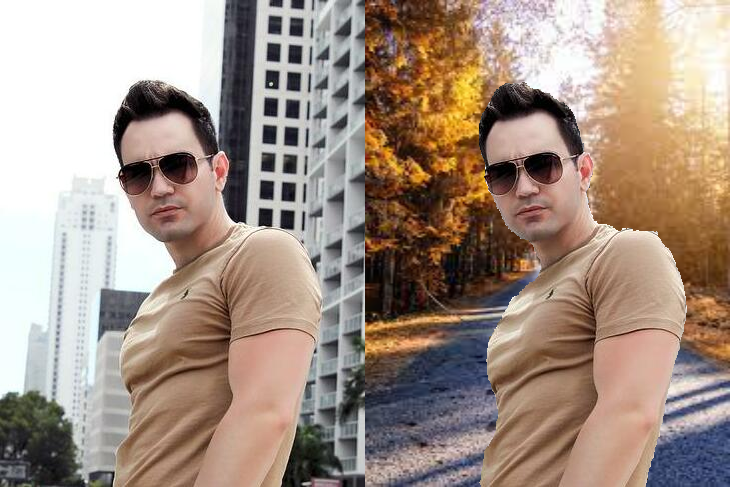

In [12]:
img = cv2.imread("/content/sample_data/original image.jpeg")
background = cv2.imread("/content/sample_data/background image.jpg")
background = cv2.resize(background, (img.shape[1], img.shape[0]))

segmentor = SelfiSegmentation()
imgOut = segmentor.removeBG(img, background, threshold=0.8)

imgStack = cvzone.stackImages([img, imgOut], 2,1) #stacking the original image and the changed background image
cv2_imshow(imgStack)

In [13]:
#saving the image for later use
cv2.imwrite("/content/sample_data/segmented_image.png", imgOut)

True

In [14]:
# defining a function that accepts an image and return the face bbox for adding the hat just above it
def roi_face(img):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5, flags=cv2.CASCADE_SCALE_IMAGE)

    for (x, y, w, h) in faces:
      return x,y,w,h

In [15]:
seg_img = cv2.imread("/content/sample_data/segmented_image.png") # reading the segmented image with new background
f_copy = seg_img.copy()
x,y,w,h = roi_face(f_copy) 

In [16]:
def put_hat(hat,face,x,y,w,h):
    face_width = w
    face_height = h
    
    # center the hat
    x1 = x + 20
    y1 = y - h + 35
    x2 = x + w +15
    y2 = y

    # resizing the hat dimensions
    hat_width = x2 - x1
    hat_height = y2 - y1
    
    hat = cv2.resize(hat,(hat_width,hat_height))
    
    for i in range(hat_height):
        for j in range(hat_width):
            for k in range(3):
                if hat[i][j][k]<235:
                    face[y+i-int(0.60*face_height)][x+j][k] = hat[i][j][k]
    return face

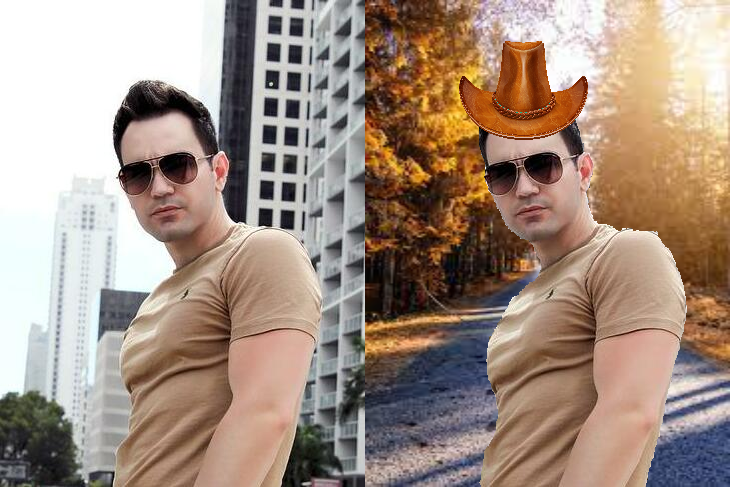

In [18]:
hat = cv2.imread("/content/sample_data/cowboy_hat.png")
final_img = put_hat(hat, f_copy, x, y, w, h)

imgStack2 = cvzone.stackImages([img, final_img], 2,1) #stacking the segmented image and the final image with hat
cv2_imshow(imgStack2)

In [35]:
cv2.imwrite("/content/sample_data/final_image.png", final_img)
cv2.imwrite("/content/sample_data/stacked_image_with_output.png", imgStack2)

True

## Adding snow effect to final image

In [32]:
background_img = cv2.imread('/content/sample_data/final_image.png')
snowflakes = []
sf_size = 7
for i in range(3):
    snowflake_img = cv2.imread(f'/content/sample_data/snowflake-{i}.png', -1)
    small_snowflake = cv2.resize(snowflake_img, (sf_size , sf_size))
    snowflakes.append(small_snowflake)

In [33]:
y, x, _ = background_img.shape
sf_pos = [] # stores snowflakes position
for i in range(200): # quantity of snowflakes are 50
    temp_x = random.choice(range(50, x-sf_size))
    temp_y = random.choice(range(50, y-sf_size))
    sf_pos.append([temp_y, temp_x])

In [34]:
with imageio.get_writer("final_image_with_snow.gif", mode="I") as writer:
    for i in range(200): # quantity of frames
        frame = background_img
        for j in range(200): # should be same as snowflakes quantity
            frame = overlayPNG(frame, snowflakes[j%3], (sf_pos[j][1], sf_pos[j][0])) # snowflakes list used to make 3 model of snowflake
            sf_pos[j][0] += 4
            rnd_x = random.choices([0, 4, -4], weights=[30,35,35])[0]
            sf_pos[j][1] += rnd_x
            if sf_pos[j][0]<0 or sf_pos[j][0]+sf_size>=y or sf_pos[j][1]<0 or sf_pos[j][1]+sf_size>=x:
                sf_pos[j][0] = 0
                sf_pos[j][1] = random.randint(0, x-sf_size-1) # 10+1:sf_size+1 for array ending
                
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        writer.append_data(rgb_frame)